In [1]:
cd ..

/home/wesg/research/ordinal-probing


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from load import load_model
import datasets
import seaborn as sns

from feature_datasets.common import *
import utils
import os

from save_activations import load_activation_probing_dataset
from probe_experiment import load_probe_results
from analysis.generalization import*
from analysis.probe_plots import *

from sklearn.decomposition import PCA


%matplotlib inline

In [3]:
MODEL_LAYER = {
    'Llama-2-7b-hf': 20,
    'Llama-2-13b-hf': 24,
    'Llama-2-70b-hf': 48,
}

ACTIVATION_CONFIGS = {
    'World Map': ('world_place', 'coords'),
    'USA Map': ('us_place', 'where_us'),
    # 'NYC Map': ('nyc_place', 'where_nyc_normalized'),
    # 'Historical Figures': ('historical_figure', 'empty'),
    # 'Entertainment': ('art', 'release'),
    # 'Headlines': ('headline', 'article_w_period'),
}

activations = {}
for name, (entity_type, prompt_name) in ACTIVATION_CONFIGS.items():
    for model, layer in MODEL_LAYER.items():
        activations[(name, model)] = load_activation_probing_dataset(
            model, entity_type, prompt_name, layer).dequantize()

In [62]:
world_df = load_entity_data('world_place')
us_df = load_entity_data('us_place')

In [6]:
world_df

,name,entity_subtype,country,latitude,longitude,has_thumbnail,page_views,entity_type,total_area,population,is_test
0,Tancredo Neves Pantheon of the Fatherland and ...,Monument,Brazil,-15.80170,-47.86030,1,7521.0,structure,NaN,NaN,False
1,Sembuwatta Lake,AmusementParkAttraction,Sri_Lanka,7.43694,80.69970,1,16340.0,structure,NaN,NaN,False
2,Ford Rotunda,AmusementParkAttraction,United_States,42.31210,-83.17670,1,40773.0,structure,NaN,NaN,False
3,Afsluitdijk,Bridge,Netherlands,53.00000,5.16667,1,227321.0,structure,NaN,NaN,False
4,Mudeirej Bridge,Bridge,Lebanon,33.80080,35.72710,1,5623.0,structure,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...
39580,La Poudre Pass Lake,NaturalPlace,United_States,40.47330,-105.82500,0,19310.0,natural_place,NaN,NaN,False
39581,Lac Le Jeune,NaturalPlace,Canada,50.48300,-120.47700,1,7050.0,natural_place,NaN,NaN,True
39582,Khatanga Gulf,NaturalPlace,Russia,73.75000,109.00000,1,16258.0,natural_place,NaN,NaN,True
39583,Karimata Strait,NaturalPlace,Indonesia,-2.08333,108.66700,1,32778.0,natural_place,NaN,NaN,True


In [64]:
is_test = us_df.state_id.values == 'CA'
y = us_df.latitude.values
x = us_df.longitude.values

x_train_rank = rankdata(x[~is_test])
x_test_rank = rankdata(x[is_test])
y_train_rank = rankdata(y[~is_test])
y_test_rank = rankdata(y[is_test])


In [65]:
from probes.rank import *

In [68]:
activation = activations[('USA Map', 'Llama-2-70b-hf')]

In [69]:
activation.shape

torch.Size([29997, 8192])

In [70]:
x_probe = SpearmanRankProbe(activation.shape[1])
y_probe = SpearmanRankProbe(activation.shape[1])

In [71]:
x_probe.fit(activation[~is_test], torch.tensor(x_train_rank), verbose=True)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 | Train Spearman: 0.10022198850654593 | Loss: 112948079.7902078 | Weight norm: 0.5714514851570129
Epoch: 1 | Train Spearman: 0.3922065448486283 | Loss: 76295613.21711253 | Weight norm: 0.5780867338180542
Epoch: 2 | Train Spearman: 0.6189757966663403 | Loss: 47829540.383777015 | Weight norm: 0.5889997482299805
Epoch: 3 | Train Spearman: 0.6221034367439727 | Loss: 47436930.20079649 | Weight norm: 0.6009981036186218
Epoch: 4 | Train Spearman: 0.6465378466244557 | Loss: 44369700.85952272 | Weight norm: 0.6130351424217224
Epoch: 5 | Train Spearman: 0.780946319196223 | Loss: 27497560.953787703 | Weight norm: 0.6244529485702515
Epoch: 6 | Train Spearman: 0.7982189004868935 | Loss: 25329349.078375626 | Weight norm: 0.636198878288269
Epoch: 7 | Train Spearman: 0.7723291698908743 | Loss: 28579253.30585622 | Weight norm: 0.6481263637542725
Epoch: 8 | Train Spearman: 0.777418668247044 | Loss: 27940377.784400146 | Weight norm: 0.6598001718521118
Epoch: 9 | Train Spearman: 0.811546864964554

In [72]:
y_probe.fit(activation[~is_test], torch.tensor(y_train_rank), verbose=True)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 | Train Spearman: 0.01816936670125411 | Loss: 123248065.23684348 | Weight norm: 0.5797871351242065
Epoch: 1 | Train Spearman: 0.4747672266642869 | Loss: 65931881.259794876 | Weight norm: 0.5867290496826172
Epoch: 2 | Train Spearman: 0.3182503177143465 | Loss: 85579264.76778036 | Weight norm: 0.595049262046814
Epoch: 3 | Train Spearman: 0.3228203956253462 | Loss: 85005578.89105943 | Weight norm: 0.6061249375343323
Epoch: 4 | Train Spearman: 0.3383313898828933 | Loss: 83058495.28968935 | Weight norm: 0.6179496049880981
Epoch: 5 | Train Spearman: 0.3524687565347538 | Loss: 81283863.60998237 | Weight norm: 0.6300894021987915
Epoch: 6 | Train Spearman: 0.36530454650737737 | Loss: 79672589.46455723 | Weight norm: 0.6422237157821655
Epoch: 7 | Train Spearman: 0.3780266025276323 | Loss: 78075610.9699534 | Weight norm: 0.6541851162910461
Epoch: 8 | Train Spearman: 0.3886648166907305 | Loss: 76740204.11233915 | Weight norm: 0.6658626198768616
Epoch: 9 | Train Spearman: 0.395287480490251

In [73]:
projection_vec = x_probe.get_feature_direction()
projection = activation @ projection_vec

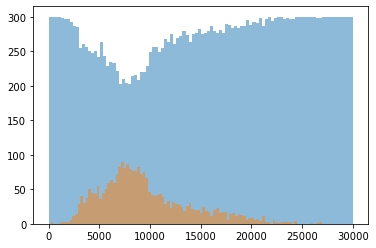

In [74]:
projection_rank = rankdata(projection)
plt.hist(projection_rank[~is_test], bins=100, alpha=0.5, label='train')
plt.hist(projection_rank[is_test], bins=100, alpha=0.5, label='test');

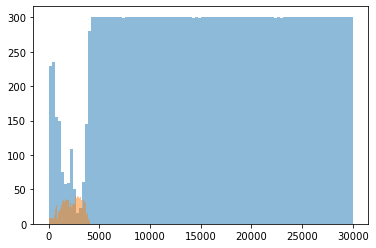

In [75]:
x_rank = rankdata(x)

plt.hist(x_rank[~is_test], bins=100, alpha=0.5, label='train')
plt.hist(x_rank[is_test], bins=100, alpha=0.5, label='test');

In [76]:
projection_vec_y = y_probe.get_feature_direction()
projection_y = activation @ projection_vec_y

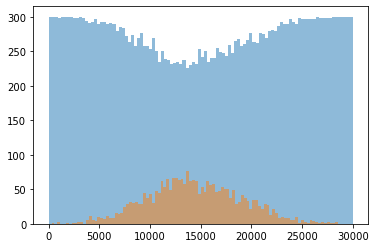

In [77]:
projection_rank_y = rankdata(projection_y)
plt.hist(projection_rank_y[~is_test], bins=100, alpha=0.5, label='train')
plt.hist(projection_rank_y[is_test], bins=100, alpha=0.5, label='test');

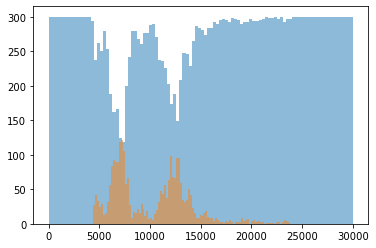

In [79]:
y_rank = rankdata(y)

plt.hist(y_rank[~is_test], bins=100, alpha=0.5, label='train')
plt.hist(y_rank[is_test], bins=100, alpha=0.5, label='test');